In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from trajectories import TrajectoriesDataset, StateFullTrajectoriesDataset, preprocess_dataset, find_activations
from torch.utils.data import DataLoader
import os

%load_ext autoreload
%autoreload 2

Getting uniques..
Got uniques. Plotting...
Positive: 43 | Negative: 3547


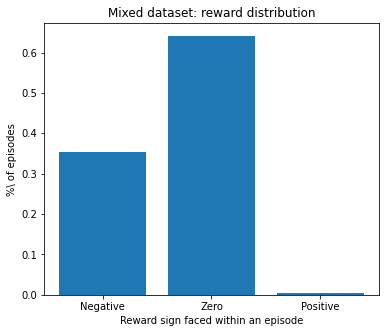

In [2]:
data_path = 'agents/MiniGrid-Triggers-3x3-T3P1-v0/random/trajectories/train_10000.pt'
dataset = torch.load(data_path)

rewards = dataset.rewards

print('Getting uniques..')
unique_rewards_per_episode = [torch.unique(rewards[episode]).tolist() for episode in range(rewards.shape[0])]
print('Got uniques. Plotting...')

n_episodes_positive_reward = 0
n_episodes_negative_reward = 0
for episode_reward_vals in unique_rewards_per_episode:
    if 2 in episode_reward_vals:
        n_episodes_positive_reward += 1
    if 0 in episode_reward_vals:
        n_episodes_negative_reward += 1

n_episodes_no_reward = rewards.shape[0] - n_episodes_positive_reward - n_episodes_negative_reward
reward_vals = torch.tensor([n_episodes_negative_reward, n_episodes_no_reward, n_episodes_positive_reward])

print(f'Positive: {n_episodes_positive_reward} | Negative: {n_episodes_negative_reward}')


plt.figure(figsize=(6,5))
plt.title('Mixed dataset: reward distribution')
plt.xlabel('Reward sign faced within an episode')
plt.ylabel('%\ of episodes')
plt.bar(torch.arange(0, 3)-1, reward_vals/torch.sum(reward_vals), tick_label=['Negative', 'Zero', 'Positive'])
plt.show()


# del n_episodes_no_reward
# del dataset
# del rewards
# del reward_vals
# import gc
# gc.collect()

Getting uniques..
Got uniques. Plotting...
Positive: 310 | Negative: 20975


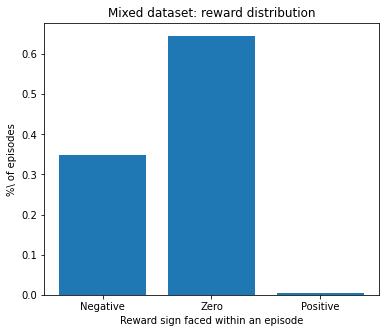

In [3]:
data_path = 'agents/MiniGrid-Triggers-3x3-T3P1-v0/random/trajectories/train_60000.pt'
dataset = torch.load(data_path)

rewards = dataset.rewards

print('Getting uniques..')
unique_rewards_per_episode = [torch.unique(rewards[episode]).tolist() for episode in range(rewards.shape[0])]
print('Got uniques. Plotting...')

n_episodes_positive_reward = 0
n_episodes_negative_reward = 0
for episode_reward_vals in unique_rewards_per_episode:
    if 2 in episode_reward_vals:
        n_episodes_positive_reward += 1
    if 0 in episode_reward_vals:
        n_episodes_negative_reward += 1

n_episodes_no_reward = rewards.shape[0] - n_episodes_positive_reward - n_episodes_negative_reward
reward_vals = torch.tensor([n_episodes_negative_reward, n_episodes_no_reward, n_episodes_positive_reward])

print(f'Positive: {n_episodes_positive_reward} | Negative: {n_episodes_negative_reward}')


plt.figure(figsize=(6,5))
plt.title('Mixed dataset: reward distribution')
plt.xlabel('Reward sign faced within an episode')
plt.ylabel('%\ of episodes')
plt.bar(torch.arange(0, 3)-1, reward_vals/torch.sum(reward_vals), tick_label=['Negative', 'Zero', 'Positive'])
plt.show()


# del n_episodes_no_reward
# del dataset
# del rewards
# del reward_vals
# import gc
# gc.collect()

In [4]:
dir(dataset)

['__add__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_is_protocol',
 'actions',
 'compute_pad_mask',
 'observations',
 'rewards']

In [26]:
positive_episode_observations = []
positive_episode_actions = []
positive_episode_rewards = []

indices = []

for i, episode_reward_vals in enumerate(unique_rewards_per_episode):
    if 2 in episode_reward_vals:
        # episode with positive rewards, remember it
        indices.append(i)
        positive_episode_observations.append(dataset.observations[i])
        positive_episode_actions.append(dataset.actions[i])
        positive_episode_rewards.append(dataset.rewards[i])

print(len(positive_episode_observations))
print(indices)

310
[27, 400, 535, 718, 797, 882, 1069, 1152, 1175, 1529, 1705, 1735, 1925, 2000, 2399, 2494, 2514, 2586, 2594, 2706, 2967, 3041, 3088, 3395, 3749, 3925, 4188, 4829, 4991, 5002, 6008, 6182, 6563, 6664, 6695, 7044, 7046, 7224, 7247, 7298, 7387, 7577, 8134, 8510, 8681, 8913, 9078, 9606, 9716, 9798, 9962, 10294, 10318, 10381, 10462, 10501, 10922, 11097, 11453, 11650, 11978, 12314, 12875, 13039, 13097, 13268, 13429, 13473, 13753, 14082, 14437, 14783, 15232, 15323, 15358, 15492, 15748, 15927, 16014, 16090, 16161, 16653, 16922, 17438, 17515, 17813, 17840, 18455, 18841, 19034, 19084, 19120, 19185, 19320, 19373, 19418, 19633, 19764, 19903, 20008, 20228, 20667, 20825, 21200, 21275, 21422, 21580, 21814, 22109, 22206, 22260, 22388, 23448, 23654, 23655, 23899, 23982, 24174, 24279, 24544, 24640, 24833, 24869, 24935, 24954, 25062, 25498, 25780, 26172, 26260, 26403, 27040, 27062, 27815, 27976, 28138, 28160, 28191, 28293, 28471, 28529, 28608, 28643, 29065, 29069, 29281, 29299, 29368, 29455, 29491, 295

action: tensor([0., 0., 1.])
reward: tensor(2)


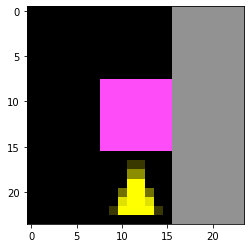

In [24]:
step = 45
plt.imshow(positive_episode_observations[0][step].type(torch.int32))
print('action:', positive_episode_actions[0][step])
print('reward:', positive_episode_rewards[0][step])

action: tensor([0., 0., 1.])
reward: tensor(2)


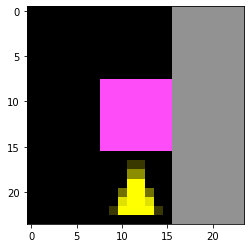

In [27]:
episode = 27
step = 45
plt.imshow(dataset.observations[episode][step].type(torch.int32))
print('action:', dataset.actions[episode][step])
print('reward:', dataset.rewards[episode][step])